<a href="https://colab.research.google.com/github/nikhilkr31/pet-breed-classifier/blob/main/pet-breed-classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [ ]:
# import os
# os.environ['PYTORCH_ENABLE_MPS_FALLBACK']='1'

In [ ]:
#imports
from fastai.vision.all import *
path = untar_data(URLs.PETS)

from utils import *

## Multi-label Classification

In [ ]:
path.ls()
(path/"images").ls()
fname = (path/"images").ls()[0]
re.findall(r'(.+)_\d+.jpg$', fname.name)

pets = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(seed=42),
                 get_y=using_attr(RegexLabeller(r'(.+)_\d+.jpg$'), 'name'),
                 item_tfms=Resize(460),
                 batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = pets.dataloaders(path/"images")

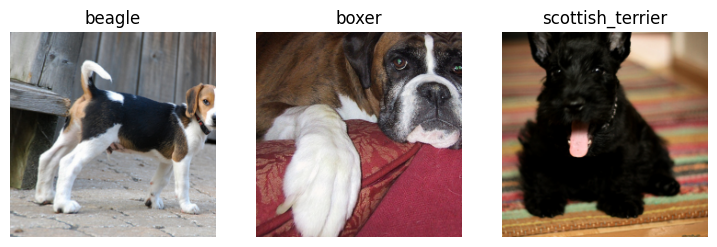

In [ ]:
dls.show_batch(nrows=1,ncols=3)

In [ ]:
#Fine tuning the model


learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 97.8MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.514781,0.355436,0.121110,01:14


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,error_rate,time
0,0.520010,0.326262,0.105548,01:19
1,0.324020,0.234522,0.071042,01:18


## Softmax function

In [ ]:
# the labels of the pers in a single batch. THe numbers range anything from
# 1 to 37 for the different pet breeds in the datasets
x,y = dls.one_batch()
y

TensorCategory([10, 16,  6, 13,  5,  0, 19, 28, 29, 36,  0, 25, 17, 30, 24,  3,
                 0, 26,  4, 21, 35, 12, 20, 25, 20,  4,  8, 31, 13, 25, 21,  0,
                 6,  0, 34,  6, 31,  5, 14, 20, 17, 33,  4, 27, 11, 33, 10, 26,
                19, 18, 22, 30, 33,  2,  7,  9, 18, 30, 31, 34, 17, 19, 34, 32],
               device='cuda:0')

In [ ]:
# predictions -> the activations of the final layer of the neural network
preds,_ = learn.get_preds(dl=[(x,y)])

In [ ]:
#show predictions
preds[0]

tensor([3.5595e-05, 2.4844e-07, 4.5933e-05, 4.7350e-06, 6.0095e-08, 1.0613e-06,
        8.6991e-09, 1.6735e-09, 3.3103e-05, 2.1658e-07, 9.9984e-01, 1.2076e-06,
        1.0870e-08, 7.6790e-09, 1.0023e-07, 2.3569e-08, 2.0178e-08, 3.9414e-05,
        1.3497e-07, 6.0775e-09, 8.2331e-09, 3.4303e-08, 8.5579e-09, 3.8102e-08,
        5.4224e-09, 5.6802e-08, 3.2976e-07, 2.7814e-09, 3.8025e-08, 2.4350e-07,
        2.3263e-07, 7.3379e-09, 1.2243e-08, 2.5790e-07, 1.2439e-08, 1.0921e-07,
        2.7948e-08])

In [ ]:
#the tensors add upto 1
preds[0].sum()

tensor(1.0000)

The model is using a softmax function to ensure the activations are between 0 and 1.

In [ ]:
#Neural net which predicts 3's and 7's like the last example

#Assume we have 6 images and 2 categories(3,7)

acts = torch.randn((6,2))*2
acts

tensor([[-1.2777,  1.2582],
        [ 1.1777,  2.5570],
        [-1.6045, -3.3076],
        [ 2.2148, -2.0914],
        [-0.8381, -4.8215],
        [-2.7693,  3.2209]])

In [ ]:
# Applying Sigmoid

acts.sigmoid()

tensor([[0.2179, 0.7787],
        [0.7645, 0.9280],
        [0.1674, 0.0353],
        [0.9016, 0.1099],
        [0.3019, 0.0080],
        [0.0590, 0.9616]])

Applying Sigmoid doesn't work because the probabilities dont add upto 1. It would make it difficult for us to choose the most likely category.

In binary cases, a single pair of activations simply indicate that relative confidence of the input being a 3 versus being a 7.

The implication being that the difference between the neural net activations reflects how much more sure the input is a 3 over a 7. Then we can take the sigmoid of that.

In [ ]:
(acts[:,0] - acts[:,1]).sigmoid()

tensor([0.0734, 0.2011, 0.8459, 0.9867, 0.9817, 0.0025])

In [ ]:
#code for softmax function

def softmax(x):
  return exp(x)/exp(x).sum(dim=1,keepdim=True)

In [ ]:
sm_acts = torch.softmax(acts,dim=1)
sm_acts

tensor([[0.0734, 0.9266],
        [0.2011, 0.7989],
        [0.8459, 0.1541],
        [0.9867, 0.0133],
        [0.9817, 0.0183],
        [0.0025, 0.9975]])

The softmax is the multi-category equivalent of sigmoid

## Log Likelihood

In [ ]:
targ = tensor([0,1,0,1,1,0])
sm_acts

tensor([[0.0734, 0.9266],
        [0.2011, 0.7989],
        [0.8459, 0.1541],
        [0.9867, 0.0133],
        [0.9817, 0.0183],
        [0.0025, 0.9975]])

In [ ]:
idx = range(6)
sm_acts[idx, targ]

tensor([0.0734, 0.7989, 0.8459, 0.0133, 0.0183, 0.0025])

Torch offer a similar function that does exactly the same.It is called Negative Log Likelihood.

In [ ]:
-sm_acts[idx, targ]

tensor([-0.0734, -0.7989, -0.8459, -0.0133, -0.0183, -0.0025])

In [ ]:
F.nll_loss(sm_acts, targ, reduction = 'none')

tensor([-0.0734, -0.7989, -0.8459, -0.0133, -0.0183, -0.0025])

Even though 'nll' stands for log likelihood, PyTorch doesn't take the log for you. It has another function calleld log_softmax which combines log and softmax. nll_loss is designed to be used after log_softmax.

Softmax -> Log likelihood, this combination is calleld cross-entropy loss. In PyTorch, this is available as nn.CrossEntropyLoss.

In [ ]:
loss_func = nn.CrossEntropyLoss()

In [ ]:
loss_func(acts, targ)

tensor(2.8864)

In [ ]:
F.cross_entropy(acts, targ)

tensor(2.8864)

## Model Interpretation

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/fastai/interpret.py:149: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


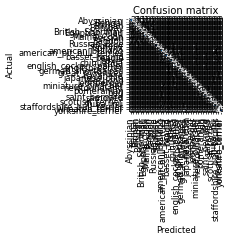

In [ ]:
interp.plot_confusion_matrix(figsize=(12,2), dpi = 60)

In [ ]:
interp.most_confused(min_val=5)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[('Birman', 'Ragdoll', 7),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 7),
 ('Egyptian_Mau', 'Bengal', 6)]

## Making the model better

Using a learning rate finder

In [ ]:
learn = cnn_learner(dls, resnet34, metrics = error_rate)
learn.fine_tune(1, base_lr=0.1)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,2.616584,4.489579,0.466170,01:17


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,error_rate,time
0,4.026886,2.959672,0.753721,01:15


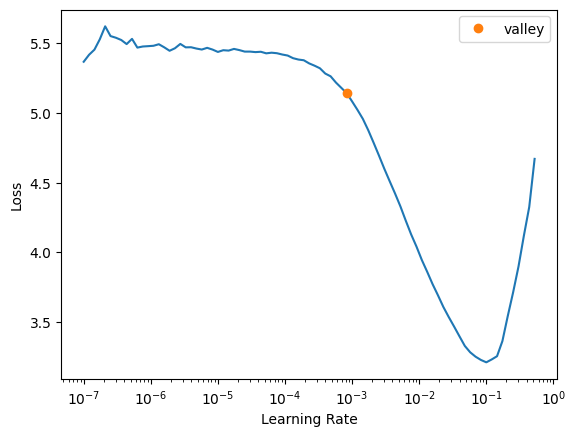

In [ ]:
#using a learning rate finder

learn = cnn_learner(dls, resnet34, metrics = error_rate)
lr_opt = learn.lr_find()

In [ ]:
learn = cnn_learner(dls, resnet34, metrics = error_rate)
learn.fine_tune(1, base_lr=8e-4)

/usr/local/lib/python3.10/dist-packages/fastai/vision/learner.py:301: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,error_rate,time
0,2.136974,0.461144,0.148850,01:16


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,error_rate,time
0,0.606558,0.306031,0.100812,01:17


## Unfreezing and Transfer Learning



1.   ??
2.   Regular expressions are used to represent a set words or characters into compact syntax
3.
4. NO
5. Path Library
6. Augmentation can degrade the quality of the data depending on the transformation applied.
7. show_batch()
8. summary()
9. Not necessarily but its probably a good idea if the model requires a lot of compute
10. Softmax function and Log Likelihood
11. It ensures that:
  - The activations are positive and between 0 and 1.
  - They add upto 1
12. If we are not using cross-entropy loss then these properties might be the most useful
13.

14. torch.where is useful in case of binary classifier. Multi label classifier requires more sofisticated loss functions
15. e**-2
16. - Right before the slope
 - Divide by an order of 10
17. - Freezes the model and initiates a linear with random weights and does